# 2.4.2 [Challenge: make your own regressino model](https://courses.thinkful.com/data-201v1/project/2.4.4)

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

Build a Regression model to predict property crimes. Use previous features, new features or combination. 

Goal: Prediction rather than understanding mechanisms, focus on model that explains alot of variance.

$$ property crime = burglary + larceny + motor vehicle theft$$  

$$ violent crime = murder + rape + robbery + aggravated assault$$

### Write up on feature engineering & selection
When just looking for predictive power of a model trying to predict property crime, using burglary, larceny & motorvehicle theft along with population what the highest R-squared, I later realized that is because the definition of property crimce is burglary, larceny & motor vehicle theft added together (atleast in this data set). 

Considering this, the model is likely very overfit. I making the errors more consistant across the dataset by cutting the extremely high populations (outside of 75 quartile) to the value of the 75th quartile. This brought the errors closer to a line but really hurt the R-squared. 

In [75]:
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
import statsmodels.formula.api as smf
from IPython.display import display
from sklearn.model_selection import cross_validate


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [130]:
# Grab and process the raw data.
data_path = ("unit_2_data/ny_crime_data.csv")
df_crime = pd.read_csv(data_path, header=None, delimiter=',')
df_crime.columns = list(df_crime.iloc[4,:])
df_crime.columns = df_crime.columns.str.replace('\n', '_').str.replace(' ', '_').str.lower()
df_crime = df_crime.rename({'murder_and_nonnegligent_manslaughter':'murder',
                            'rape_(legacy_definition)2':'rape',
                           'larceny-_theft':'larceny',
                           'arson3':'arson'},axis='columns')

df_crime = pd.concat([df_crime.iloc[5:-3,0:4],df_crime.iloc[5:-3,5:-1]],axis=1).reset_index(drop=True)

for crime in list(df_crime.columns[1:]):
    df_crime[crime] = df_crime[crime].str.replace(',','').astype('int64')
    
crime_list = df_crime.columns[2:]

for crime in crime_list:
    df_crime[crime + str('_per_capita')] = df_crime[crime]/df_crime['population']
    
# create flags for >0 crimes
for crime in crime_list:
    df_crime[crime+str('_flag')] = np.where(df_crime[crime]>0,1,0)
    
df_crime['population_squared'] = df_crime['population']**2 

df_crime = df_crime.loc[df_crime['city']!='New York'].reset_index(drop=True)

In [132]:
df_crime.rape

0       0
1       0
2       0
3      30
4       3
5       0
6       0
7       7
8       2
9       0
10      0
11      0
12      0
13      0
14     20
15      0
16      0
17      0
18      7
19      1
20      0
21      0
22     19
23      0
24      1
25      0
26      0
27      0
28      0
29      0
       ..
317     0
318     0
319     3
320    27
321     2
322     2
323     3
324     1
325     1
326     0
327     0
328     0
329    12
330     3
331     0
332     0
333     2
334     0
335     1
336     0
337     1
338     0
339     3
340     0
341     0
342     0
343     0
344     0
345    25
346     0
Name: rape, Length: 347, dtype: int64

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


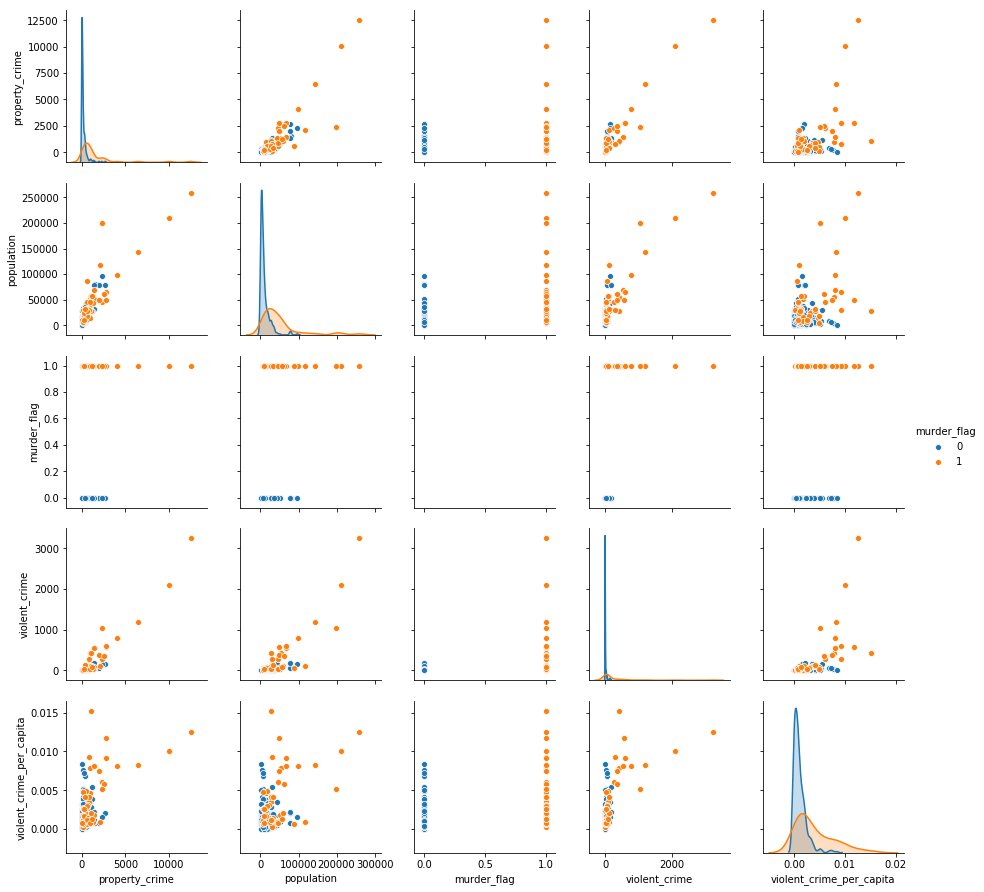

In [135]:
sns.pairplot(df_crime[['property_crime', 'population',
                      'murder_flag','violent_crime', 'violent_crime_per_capita']], hue='murder_flag')
plt.show()

In [86]:
df_crime[['property_crime', 'burglary', 'larceny', 'motor_vehicle_theft']]

,property_crime,burglary,larceny,motor_vehicle_theft
0,12,2,10,0
1,24,3,20,1
2,16,1,15,0
3,4090,705,3243,142
4,223,53,165,5
5,46,10,36,0
6,10,0,10,0
7,2118,204,1882,32
8,210,16,188,6
9,405,99,291,15


In [77]:
df_crime.columns

Index(['city', 'population', 'violent_crime', 'murder', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'violent_crime_per_capita', 'murder_per_capita',
       'robbery_per_capita', 'aggravated_assault_per_capita',
       'property_crime_per_capita', 'burglary_per_capita',
       'larceny_per_capita', 'motor_vehicle_theft_per_capita',
       'violent_crime_flag', 'murder_flag', 'robbery_flag',
       'aggravated_assault_flag', 'property_crime_flag', 'burglary_flag',
       'larceny_flag', 'motor_vehicle_theft_flag', 'population_squared'],
      dtype='object')

In [ ]:
# Try Transformations with 

In [52]:
# Grab and process the raw data.
df_crime2014 = pd.read_csv("unit_2_data/crime_2014.csv", header=None, delimiter=',')
df_crime2014.columns = list(df_crime2014.iloc[4,:])
df_crime2014.columns = df_crime2014.columns.str.replace('\n', '_').str.replace(' ', '_').str.lower()
df_crime2014 = df_crime2014.rename({'murder_and_nonnegligent_manslaughter':'murder',
                           'larceny-_theft':'larceny',
                           'arson3':'arson'},axis='columns')

df_crime2014 = pd.concat([df_crime2014.iloc[5:-7,0:4],df_crime2014.iloc[5:-7,6:-2]],axis=1).reset_index(drop=True)
df_crime2014 = df_crime2014[df_crime2014['city']!=df_crime2014.iloc[364,0]]
for crime in list(df_crime2014.columns[1:]):
    df_crime2014[crime] = df_crime2014[crime].str.replace(',','').astype('int64')
    
crime_list2014 = df_crime2014.columns[2:]
for crime in crime_list2014:
    df_crime2014[crime + str('_per_capita')] = df_crime2014[crime]/df_crime2014['population']
    
# create flags for >0 crimes
for crime in crime_list2014:
    df_crime2014[crime+str('_flag')] = np.where(df_crime2014[crime]>0,1,0)
    
df_crime2014['population_squared'] = df_crime2014['population']**2 

df_crime2014 = df_crime2014.loc[df_crime2014['city']!='New York'].reset_index(drop=True)


In [ ]:
print(boston_df_o1 < (Q1 - 1.5 * IQR)) |(boston_df_o1 > (Q3 + 1.5 * IQR))

In [104]:
np.where(df_crime['population']>df_crime['population'].quantile(.75),1,0)

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [113]:
Q1 = df_crime['population'].quantile(0.25)
Q3 = df_crime['population'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

print((df_crime['population'] < (Q1 - 1.5 * IQR)) |(df_crime['population'] > (Q3 + 1.5 * IQR)))

15163.5
0      False
1      False
2      False
3       True
4      False
5      False
6      False
7       True
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22      True
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
317    False
318    False
319    False
320     True
321    False
322    False
323    False
324    False
325    False
326    False
327    False
328    False
329    False
330    False
331    False
332    False
333     True
334    False
335    False
336    False
337     True
338    False
339     True
340    False
341    False
342    False
343    False
344    False
345     True
346    False
Name: population, Length: 347, dtype: bool


In [115]:
df_crime['population_2'] = np.where((df_crime['population'] > (Q3 + 1.5 * IQR)),(Q3 + 1.5 * IQR), df_crime['population'])

In [109]:
df_crime['population'].quantile(0.25)

2997.0

In [110]:
Q3

18160.5

In [107]:
1.5*IQR

22745.25

In [101]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df_crime['population']))
print(z)



[5.21267600e-01 4.94789456e-01 4.84841661e-01 3.03238778e+00
 3.53856206e-01 4.38874716e-01 5.24226051e-01 3.78457417e+00
 2.38069796e-01 8.22935585e-02 5.14167315e-01 4.22825114e-01
 5.65755319e-01 4.96823391e-01 4.18373689e-01 4.66832086e-01
 3.13732202e-01 3.89727434e-01 2.15481015e-02 3.78078530e-01
 6.17692988e-02 6.76239748e-01 1.12226335e+00 5.37945872e-01
 1.46283828e-01 5.52294363e-01 5.04108579e-01 5.14130335e-01
 5.13723547e-01 5.02888218e-01 2.95130936e-01 7.66694413e-01
 2.83740897e-01 3.53782244e-01 5.46673305e-01 8.98009636e+00
 3.46866863e-01 5.21526464e-01 5.08028528e-01 3.03548776e-01
 2.02901200e-01 4.16131617e-01 5.07030050e-01 3.38842062e-01
 5.61909332e-01 6.84338510e-01 4.61358950e-01 4.47269323e-01
 5.53847551e-01 4.51448136e-01 4.89057455e-01 5.22229096e-01
 5.26001123e-01 2.30775198e+00 2.94613207e-01 4.04593655e-01
 5.03466160e-01 2.39443462e+00 5.14315238e-01 4.23564727e-01
 3.14286912e-01 8.22132028e-03 2.30235281e+00 5.22524942e-01
 1.80084140e-01 4.799602

In [102]:
threshold = 3
print(np.where(z > 3))

(array([  3,   7,  35, 271, 309, 345]),)


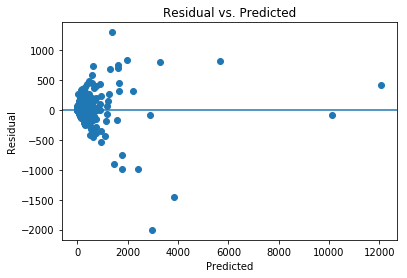

In [92]:
# First fit 
regr = linear_model.LinearRegression()
Y = df_crime['property_crime']
X = df_crime[['population', 'population_squared', 'robbery', 'murder']]
regr.fit(X, Y)

actual = df_crime['property_crime']
predicted = regr.predict(X).ravel()

residual = actual - predicted

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


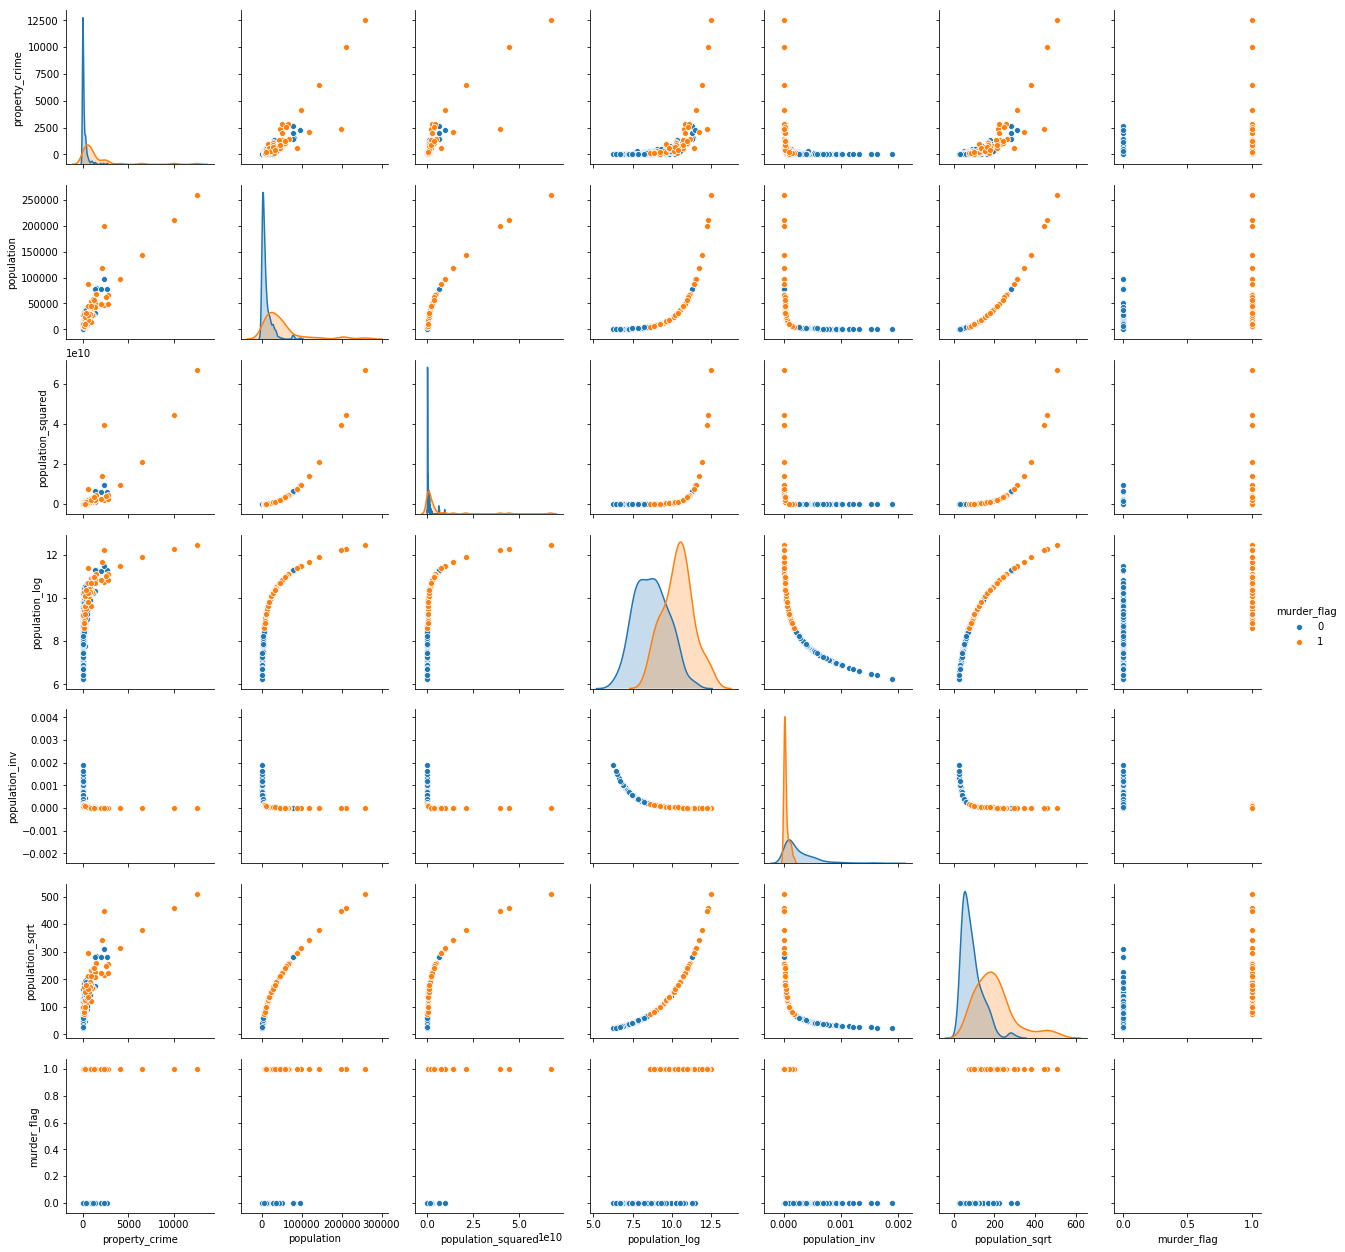

In [123]:
# Let's try a few transformations of TV to get at the non-linearity of the relationship
# We add 1 because you can't log 0.
df_crime['population_log']=np.log(df_crime['population']+1)
# We add 1 because you can't divide by 0.
df_crime['population_inv']=1/(df_crime['population']+1)
df_crime['population_sqrt']=np.sqrt(df_crime['population'])

# Look at the top row
sns.pairplot(df_crime[['property_crime','population','population_squared','population_log',
                       'population_inv','population_sqrt','murder_flag']], hue='murder_flag')
plt.show()

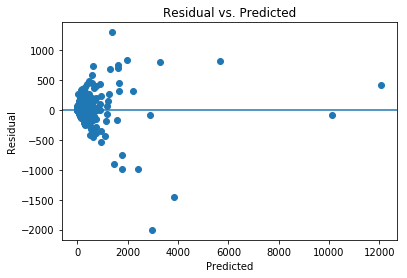

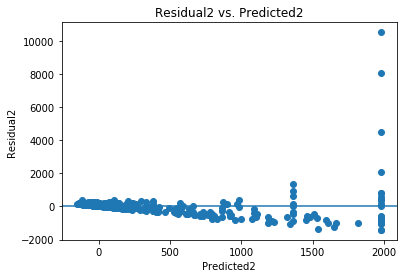

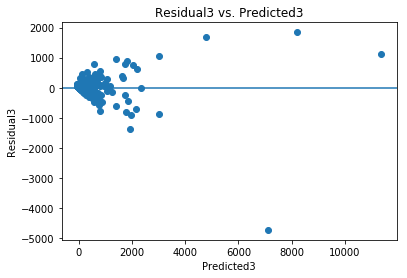

0.939283140822447
0.3361432149370549
0.8716583159298156


In [121]:
#Instantiate and fit our model.
regr2 = linear_model.LinearRegression()
#Y = df_crime['property_crime']
X2 = df_crime[['population_2', 'robbery_flag', 'murder_flag']]
regr2.fit(X2,Y)
# Results

#actual = df_crime['property_crime']
predicted2 = regr2.predict(X2).ravel()

residual2 = actual - predicted2

regr3 = linear_model.LinearRegression()
X3 = df_crime[['population', 'population_squared', 'violent_crime_per_capita']]
regr3.fit(X3,Y)
predicted3 = regr3.predict(X3).ravel()
residual3 = actual - predicted3

               
               
               
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

plt.scatter(predicted2, residual2)
plt.xlabel('Predicted2')
plt.ylabel('Residual2')
plt.axhline(y=0)
plt.title('Residual2 vs. Predicted2')
plt.show()

plt.scatter(predicted3, residual3)
plt.xlabel('Predicted3')
plt.ylabel('Residual3')
plt.axhline(y=0)
plt.title('Residual3 vs. Predicted3')
plt.show()

print(regr.score(X, Y))
print(regr2.score(X2, Y))
print(regr3.score(X3, Y))

In [70]:
#Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_crime['property_crime']
X = df_crime[['population', 'population_squared']]
regr.fit(X,Y)
# Results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
#print(pd.DataFrame(data={'variables':X.columns,'coef':regr.coef_}))

Y2 = df_crime2014['property_crime']
X2 = df_crime2014[['population', 'population_squared']]
print(regr.score(X2, Y2))


Coefficients: 
 [1.69445261e-02 1.01915089e-07]

Intercept: 
 14.901637926065746

R-squared:
0.8396738243473922
-2880.930685099193


In [54]:
Y2 = df_crime2014['property_crime']
X2 = df_crime2014[['population', 'population_squared', 'robbery', 'burglary', 'larceny']]
predict_X2 = regr.predict(X2)
#print('\nCoefficients: \n', regr.score())
#print('\nIntercept: \n', regr.intercept_)
#print('\nR-squared:')
#print(regr.score(X, Y))
#print(pd.DataFrame(data={'variables':X.columns,'coef':regr.coef_}))

In [61]:
df_crime2014.columns

Index(['city', 'population', 'violent_crime', 'murder', 'robbery',
       'aggravated_assault', 'property_crime', 'burglary', 'larceny',
       'motor_vehicle_theft', 'violent_crime_per_capita', 'murder_per_capita',
       'robbery_per_capita', 'aggravated_assault_per_capita',
       'property_crime_per_capita', 'burglary_per_capita',
       'larceny_per_capita', 'motor_vehicle_theft_per_capita',
       'violent_crime_flag', 'murder_flag', 'robbery_flag',
       'aggravated_assault_flag', 'property_crime_flag', 'burglary_flag',
       'larceny_flag', 'motor_vehicle_theft_flag', 'population_squared'],
      dtype='object')

In [63]:
#Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_crime['property_crime']
X = df_crime[['population', 'population_squared', 'murder_per_capita', 'robbery_per_capita']]
regr.fit(X,Y)

# Results

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
print(pd.DataFrame(data={'variables':X.columns,'coef':regr.coef_}))


Y2 = df_crime2014['property_crime']
X2 = df_crime2014[['population', 'population_squared', 'murder_per_capita', 'robbery_per_capita']]

#print('\nCoefficients: \n', regr.coef_)
#print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X2, Y2))
#print(pd.DataFrame(data={'variables':X.columns,'coef':regr.coef_}))



Coefficients: 
 [1.14968422e-02 9.96841184e-08 1.54488651e+06 3.00536226e+05]

Intercept: 
 -24.446720257068932

R-squared:
0.8754115410579364
            variables        coef
0          population       0.011
1  population_squared       0.000
2   murder_per_capita 1544886.511
3  robbery_per_capita  300536.226

R-squared:
-2721.325285204048


In [60]:
regr.score(X2,Y2)

0.14243744885991183

In [24]:
df_crime.sort_values(by='population', ascending=False)

,city,population,violent_crime,murder,robbery,aggravated_assault,property_crime,burglary,larceny,motor_vehicle_theft,...,motor_vehicle_theft_flag,violent_crime_per_capita_flag,murder_per_capita_flag,robbery_per_capita_flag,aggravated_assault_per_capita_flag,property_crime_per_capita_flag,burglary_per_capita_flag,larceny_per_capita_flag,motor_vehicle_theft_per_capita_flag,population_squared_flag
35,Buffalo,258789,3249,47,1322,1735,12491,3458,8076,957,...,1,1,1,1,1,1,1,1,1,1
271,Rochester,210562,2107,42,918,1055,10051,2587,6855,609,...,1,1,1,1,1,1,1,1,1,1
345,Yonkers,199134,1036,6,390,615,2368,470,1662,236,...,1,1,1,1,1,1,1,1,1,1
309,Syracuse,143834,1192,21,400,696,6473,1781,4298,394,...,1,1,1,1,1,1,1,1,1,1
7,Amherst Town,118296,107,1,31,68,2118,204,1882,32,...,1,1,1,1,1,1,1,1,1,1
3,Albany,97956,791,8,227,526,4090,705,3243,142,...,1,1,1,1,1,1,1,1,1,1
126,Greece Town,96667,151,0,60,82,2303,332,1925,46,...,1,1,0,1,1,1,1,1,1,1
266,Ramapo Town,87204,57,2,9,41,567,88,466,13,...,1,1,1,1,1,1,1,1,1,1
57,Clarkstown Town,80705,65,0,17,40,1515,99,1388,28,...,1,1,0,1,1,1,1,1,1,1
214,New Rochelle,78800,175,0,81,89,1391,150,1172,69,...,1,1,0,1,1,1,1,1,1,1


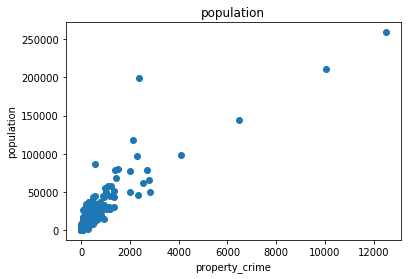

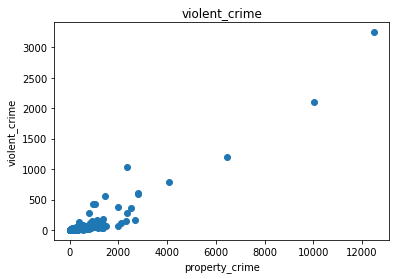

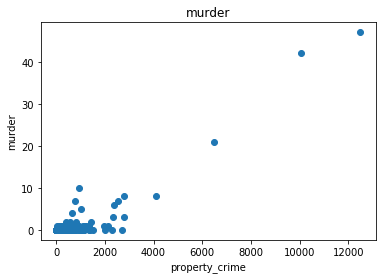

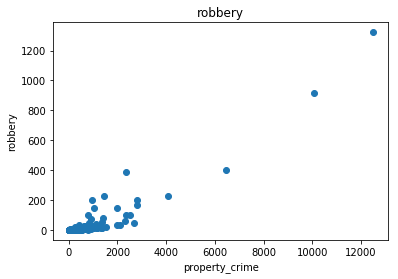

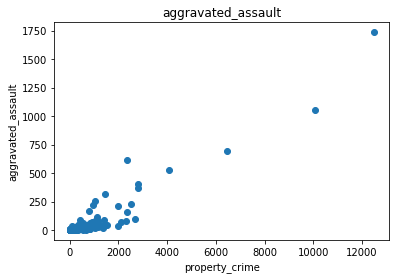

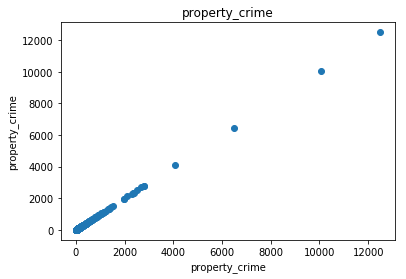

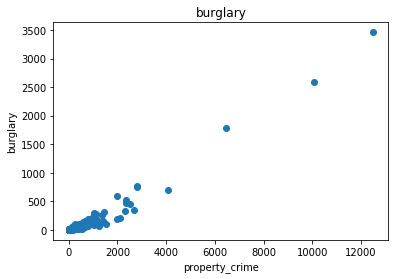

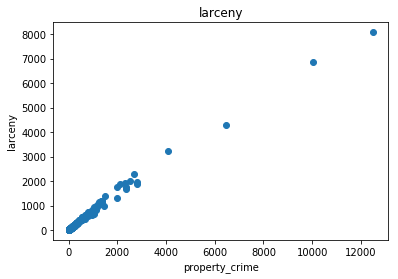

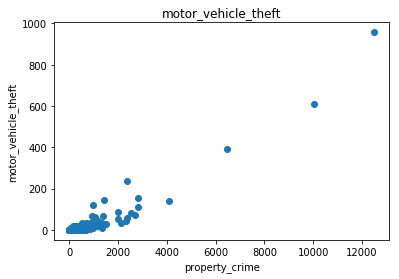

In [67]:
for crime in list(df_crime.columns[1:10]):
    plt.scatter(df_crime.property_crime, 
                df_crime[crime])
    plt.title(crime)
    plt.xlabel('property_crime')
    plt.ylabel(crime)
    plt.show()

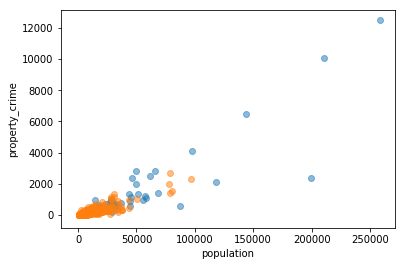

In [69]:
plt.scatter(x=crime_restricted[crime_restricted['murder']==1].population, 
            y=crime_restricted[crime_restricted['murder']==1].property_crime, alpha=0.5)
plt.scatter(x=crime_restricted[crime_restricted['murder']==0].population, 
            y=crime_restricted[crime_restricted['murder']==0].property_crime, alpha=0.5)
plt.xlabel('population')
plt.ylabel('property_crime')
plt.show()

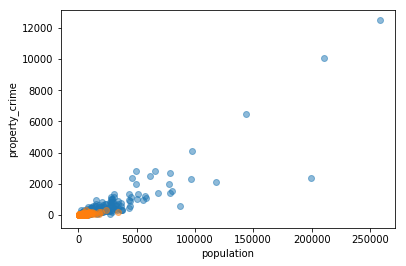

In [68]:
plt.scatter(x=crime_restricted[crime_restricted['robbery']==1].population, 
            y=crime_restricted[crime_restricted['robbery']==1].property_crime, alpha=0.5)
plt.scatter(x=crime_restricted[crime_restricted['robbery']==0].population, 
            y=crime_restricted[crime_restricted['robbery']==0].property_crime, alpha=0.5)
plt.xlabel('population')
plt.ylabel('property_crime')
plt.show()

(0, 20000)

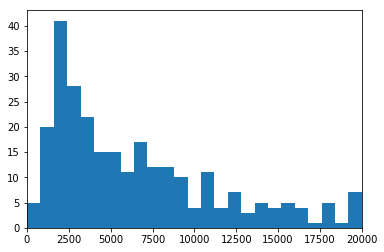

In [23]:
plt.hist(df_crime['population'], 
         bins=25, 
         range=(0,20000))
plt.xlim(0,20000)

{'whiskers': [<matplotlib.lines.Line2D at 0xa1be1e2e8>,
 'caps': [<matplotlib.lines.Line2D at 0xa1be1eba8>,
 'boxes': [<matplotlib.lines.Line2D at 0xa1be1e198>],
 'medians': [<matplotlib.lines.Line2D at 0xa1be28438>],
 'fliers': [<matplotlib.lines.Line2D at 0xa1be28860>],
 'means': []}

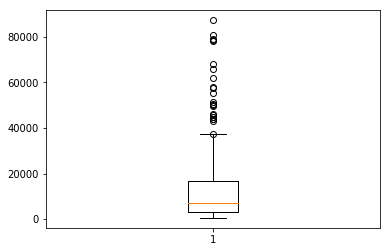

In [31]:
plt.boxplot(df_crime[df_crime['population']<90000]['population'])

In [15]:
df_crime.describe().loc['25%','population']
df_crime.describe().loc['25%','population']
df_crime.describe().loc['25%','population']

3003.0

In [95]:
crime_subset.population.describe()

count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: population, dtype: float64

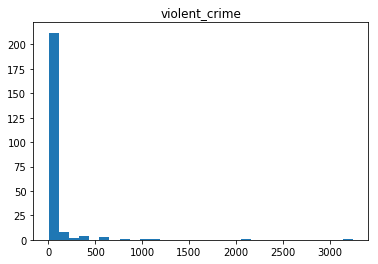

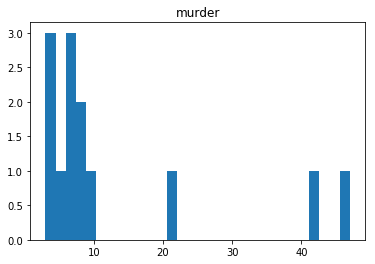

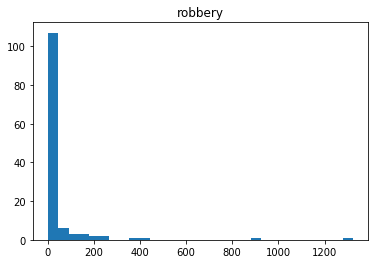

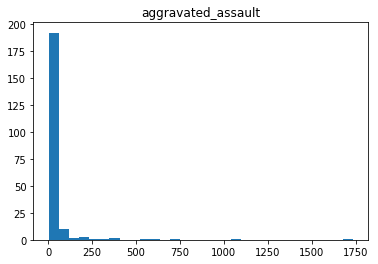

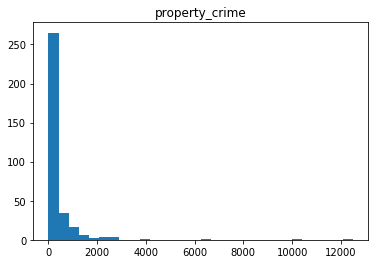

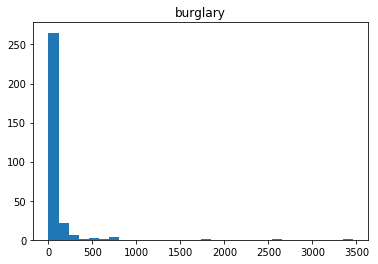

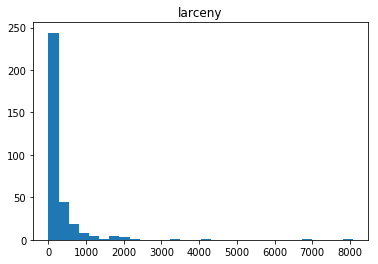

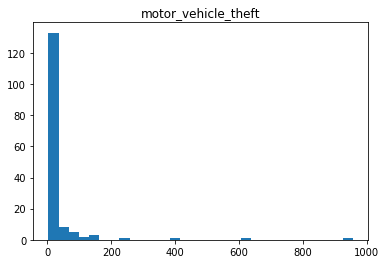

In [85]:
for crime in crime_list:
    plt.hist(df_crime[df_crime[crime]>2][crime], bins = 30)
    plt.title(crime)
    plt.show()